In [1]:
import numpy as np
import random
from scipy.linalg import eig
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib import colors
import time
from IPython import display
import statistics
from matplotlib.animation import FuncAnimation

In [2]:
"""
Global variables that will be important
"""
grid_size = 10
discount = 0.9 #we want to heavily weight future accomplishments since there is a sparse reward space
goal_locs = [0, 9, 90, 99]
n_actions = 5

In [3]:
"""
Agent functions
"""
#takes in a 1D array and returns the array noramlized and translated so all values are positive
def normalize(temp):
    m = np.min(temp)
    for i in range(0, len(temp)):
        temp[i] += abs(m)
    s = sum(temp)
    for i in range(0, len(temp)):
        temp[i] = temp[i]/s
    return temp

def action(state, qtab, epsilon=0.3):
    n = len(qtab[0]) #number of actions possible
    if random.uniform(0, 1) < 0: #epsilon:
         action = np.random.choice(list(range(0, n))) #sometimes, randomly explore (will probably make this related to if the argmax isn't high enough/not good enough option, we explore)
    else:
         action = np.argmax(qtab[state])
    
    #this one also works but the vector field isn't as pretty
    #action = np.random.choice(list(range(0, n)), p=normalize(qtab[state]))
    return action

def learn(qtab, rew, old_state, new_state, action, discount):
    #the new value for the previous action is dictated by the reward recieved and the anticipated future reward
    qtab[old_state, action] = rew + discount*(np.max(qtab[new_state]))
    return qtab

    

In [4]:
"""
Environment functions
"""
def cart_to_uni(i, j, grid_size):
    return int(grid_size*i + j)

def uni_to_cart(cart, grid_size):
    i = int(cart/grid_size)
    j = int(cart % grid_size)
    return i, j

#goal index is the index in the list of all the goal locations
def find_state(loc, goal_index, grid_size):
    return goal_index*(grid_size**2) + loc

#find the new location based on the current location, the shape of the grid, and the action taken by the agent
def find_new_loc(action, loc, grid_size):
    #0 is up, 1 is right, 2 is down, 3 is left, 4 is stay the same
    i, j = uni_to_cart(loc, grid_size)
    if action == 0:
        #i -= 1
        new_loc = cart_to_uni((i-1)%grid_size, j, grid_size)
    elif action == 1:
        #j+=1
        new_loc = cart_to_uni(i, (j+1)%grid_size, grid_size)
    elif action == 2:
        #i +=1
        new_loc = cart_to_uni((i+1)%grid_size, j, grid_size)
    elif action == 3:
        #j-=1
        new_loc = cart_to_uni(i, (j-1)%grid_size, grid_size)
    else:
        new_loc = loc
    return new_loc

#recieve the current location and the goal location in uni coordinates
def reward(loc, goal_index, goal_locs):
    if loc == goal_locs[goal_index]:
        return 20
    else:
        return -1
    
def train(qtab, loc, goal_index, goal_locs, grid_size, discount):
    #first, the agent chooses an action
    act = action(find_state(loc, goal_index, grid_size), qtab)
    #find new location based on agent action
    new_loc = find_new_loc(act, loc, grid_size)
    #find the reward for moving to the new location
    r = reward(new_loc, goal_index, goal_locs)
    #train the agent based on the move it just took and the reward
    qtab = learn(qtab, r, find_state(loc, goal_index, grid_size), find_state(new_loc, goal_index, grid_size), act, discount)
    return qtab
    
def random_init(grid_size, goal_locs):
    loc = np.random.choice(grid_size**2)
    goal_index = np.random.randint(0, len(goal_locs))
    return loc, goal_index

def test(qtab, loc, goal_index, goal_locs, grid_size, epsilon=0.3):
    #first, the agent chooses an action
    act = action(find_state(loc, goal_index, grid_size), qtab, epsilon)
    #find new location based on agent action
    new_loc = find_new_loc(act, loc, grid_size)
    return new_loc

In [12]:
"""
Display functions
"""

#in this case, the goal is sent in as a location
def grid_disp(goal_loc, loc, grid_size):
    data = np.zeros((grid_size, grid_size))
    ci, cj = uni_to_cart(loc, grid_size)
    data[ci, cj] = 1000
    gi, gj = uni_to_cart(goal_loc, grid_size)
    data[gi, gj] = 500
    cmap = colors.ListedColormap(['white', 'green','black'])
    bounds = [0,10,20]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap)
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    ax.set_xticks(np.arange(0.5, grid_size, 1))
    ax.set_yticks(np.arange(0.5, grid_size, 1))
    
def vect_disp(qtab, goal_index, grid_size):
    #based on the qtab state, get the vector for which direction the agent will head, on average
    def qtab_state_to_vec(qtab, state):
        entry = qtab[state]
        u = 0
        v = 0
        u = entry[0] - entry[2] #up and down
        v = entry[1] - entry[3] #right and left
        norm = 0
        for i in range(0, 5):
            norm += abs(entry[i])
        if norm != 0:
            u = u/norm
            v = v/norm
        return u, v
    
    xs, ys = np.linspace(0,grid_size-1,grid_size), np.linspace(0, grid_size-1, grid_size)
    us = []
    vs = []
    for x in xs:
        for y in ys:
            #first, find the uni index of the loc, determined by the x and y coordinates (i and j)
            loc = cart_to_uni(grid_size-1-x, y, grid_size)
            #then find the state
            state = find_state(loc, goal_index, grid_size)
            #then find the vectors for that particular state
            u, v = qtab_state_to_vec(qtab, state)
           # print("State: %d, <%f, %f>" %(state, u, v))
            us.append(u)
            vs.append(v)
    u = np.array(us)
    v = np.array(vs)
    x, y = np.meshgrid(xs, ys)

    fig= plt.quiver(x,y,v, u)
    plt.xticks(np.arange(0, grid_size, 1))
    plt.yticks(np.arange(grid_size-1, 0, -1))
    ax = fig.axes
    plt.show()

100


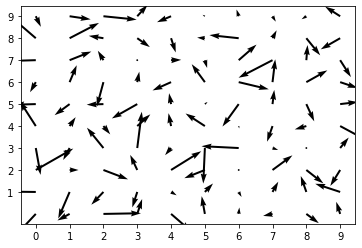

In [13]:
"""
See a vector field for randomly initiated qtab
"""
rand_qtab = np.random.rand((grid_size**2)*len(goal_locs), n_actions)
loc, goal_index = random_init(grid_size, goal_locs)
vect_disp(rand_qtab, goal_index, grid_size)

In [91]:
"""
Train a qtab
"""
qtab = np.random.rand((grid_size**2)*len(goal_locs), n_actions)
#qtab = np.zeros(((grid_size**2)*len(goal_locs), n_actions)) #this also works

#for 1000 epochs
for i in range(0, 10000):
    loc, goal_index = random_init(grid_size, goal_locs)
    #ten steps each epoch
    for j in range(0, 100):
        qtab = train(qtab, loc, goal_index, goal_locs, grid_size, discount)
        

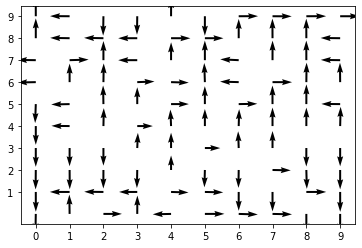

In [94]:
vect_disp(qtab, 0, grid_size)

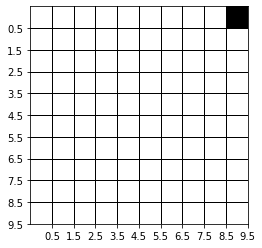

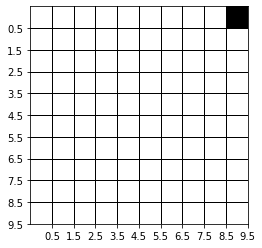

In [93]:
"""
Testing the agent
"""
loc, goal_index = random_init(grid_size, goal_locs)
goal_loc = goal_locs[goal_index]
loc = 55
r = 0 #reward
while r != 20:
    r = reward(loc, goal_index, goal_locs)
    data = np.zeros((grid_size, grid_size))
    ci, cj = uni_to_cart(loc, grid_size)
    data[ci, cj] = 1000
    gi, gj = uni_to_cart(goal_loc, grid_size)
    data[gi, gj] = 500
    cmap = colors.ListedColormap(['white', 'green','black'])
    bounds = [0,10,20]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig = plt.plot()
    plt.imshow(data, cmap=cmap)
    plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
    plt.xticks(np.arange(0.5, grid_size, 1))
    plt.yticks(np.arange(0.5, grid_size, 1))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)
    
    loc = test(qtab, loc, goal_index, goal_locs, grid_size, 0)

AttributeError: 'list' object has no attribute 'canvas'

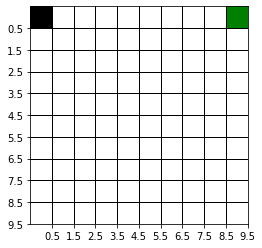

In [185]:
"""
Testing the agent and saving the animation
"""
fig = plt.plot()
plt.imshow(data, cmap=cmap)
plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
plt.xticks(np.arange(0.5, grid_size, 1))
plt.yticks(np.arange(0.5, grid_size, 1))
cmap = colors.ListedColormap(['white', 'green','black'])


loc, goal_index = random_init(grid_size, goal_locs)
goal_loc = goal_locs[goal_index]
graphworld = plt.imshow(data, cmap=cmap)
   
def animate():
    loc = test(qtab, loc, goal_index, goal_locs, grid_size)
    data = np.zeros((grid_size, grid_size))
    ci, cj = uni_to_cart(loc, grid_size)
    data[ci, cj] = 1000
    gi, gj = uni_to_cart(goal_loc, grid_size)
    data[gi, gj] = 500
    plt.imshow(data)

anim = FuncAnimation(fig, animate,frames=50, interval=1, blit=True)



    
anim.save('grid_word.mp4')

In [ ]:
def test(qtab, loc, goal_index, goal_locs, grid_size):
    #first, the agent chooses an action
    act = action(find_state(loc, goal_index, grid_size), qtab)
    #find new location based on agent action
    new_loc = find_new_loc(act, loc, grid_size)
    return new_loc